In [12]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import warnings
from sklearn.metrics import f1_score
from sklearn import metrics
warnings.filterwarnings("ignore")
%matplotlib inline

# Loading Data

In [2]:
right_hand = pd.read_csv("/home/ubuntu/Desktop/project/HandRight.csv")
def addAlone(p):
    r = right_hand 
    r = r.iloc[:len(p)-1]
    r = r.reset_index(drop=True)
    r.drop('Time', inplace=True,axis=1)
    p.set_index(' Frame ID',inplace=True)
    p = p.reset_index(drop=True)
    f = pd.concat([p,r],axis=1)
    f = f.drop([' Hand Type',' # hands',' Frame ID'],axis=1)
    return f
def addOther(p):
    r = p[p[' Hand Type']=='right']
    r.drop('Time', inplace=True,axis=1)
    l = p[p[' Hand Type']=='left']
    r.set_index(' Frame ID',inplace=True)
    l.set_index(' Frame ID',inplace=True)
    f = pd.DataFrame(pd.merge(l,r, how='left',on=' Frame ID'))
    f = f.drop([' Hand Type_x',' # hands_y' ,' Hand Type_y' ,' # hands_x'],axis=1)
    return f
def addDf(p,name,exp):
    p = p.iloc[701:]
    if 'Alone' not in exp:
        f = addOther(p)
    else:
        f = addAlone(p) 
    f.columns = ['Time', ' Position X', ' Position Y', ' Position Z', ' Velocity X', ' Velocity Y',
       ' Velocity Z', ' Pitch', ' Roll', ' Yaw', ' Wrist Pos X',
       ' Wrist Pos Y', ' Wrist Pos Z', ' Elbow pos X', ' Elbow Pos Y',
       ' Elbow Pos Z', ' Grab Strenth', ' Grab Angle', ' Pinch Strength', ' Position X r',
       ' Position Y r', ' Position Z r', ' Velocity X r', ' Velocity Y r',
       ' Velocity Z r', ' Pitch r', ' Roll r', ' Yaw r', ' Wrist Pos X r',
       ' Wrist Pos Y r', ' Wrist Pos Z r', ' Elbow pos X r', ' Elbow Pos Y r',
       ' Elbow Pos Z r', ' Grab Strenth r', ' Grab Angle r', ' Pinch Strength r']
    f.insert(loc=0, column='Name', value=name)
    f.insert(loc=1, column='Type', value=exp)
    return f

In [3]:
def loadData(pathW):
    df = pd.DataFrame(columns=[
        'Name',
        'Type',
        'Time',
        ' Position X',
        ' Position Y',
        ' Position Z',
        ' Velocity X',
        ' Velocity Y',
        ' Velocity Z',
        ' Pitch',
        ' Roll',
        ' Yaw',
        ' Wrist Pos X',
        ' Wrist Pos Y',
        ' Wrist Pos Z',
        ' Elbow pos X',
        ' Elbow Pos Y',
        ' Elbow Pos Z',
        ' Grab Strenth',
        ' Grab Angle',
        ' Pinch Strength',
        ' Position X r',
        ' Position Y r',
        ' Position Z r',
        ' Velocity X r',
        ' Velocity Y r',
        ' Velocity Z r',
        ' Pitch r',
        ' Roll r',
        ' Yaw r',
        ' Wrist Pos X r',
        ' Wrist Pos Y r',
        ' Wrist Pos Z r',
        ' Elbow pos X r',
        ' Elbow Pos Y r',
        ' Elbow Pos Z r',
        ' Grab Strenth r',
        ' Grab Angle r',
        ' Pinch Strength r',
        ])
    path = pathW
    import os
    for folder in os.listdir(path):
        c_A = 0
        c_Sp = 0
        c_Sy = 0
        for fu in os.listdir(path + folder):
            if 'Alone' in fu:
                c_A += 1
            elif 'Sync' in fu:
                c_Sy += 1
            else:
                c_Sp += 1
        for fu in os.listdir(path + folder):
            if 'Alone' in fu and c_A != 1:
                c_A -= 1
                continue
            elif 'Sync' in fu and c_Sy != 1:
                c_Sy -= 1
                continue
            elif 'Spontan' in fu and c_Sp != 1:
                c_Sp -= 1
                continue
            x = pd.read_csv(path + folder + '/' + fu)
            df = pd.concat([df, addDf(x, ''.join(filter(str.isalpha,
                           fu[:8])), ''.join(filter(str.isalpha,
                           fu[8:len(fu) - 3])))], sort=False)
    return df

In [4]:
train = loadData("/home/ubuntu/Desktop/project/Training/")
test = loadData("/home/ubuntu/Desktop/project/Validation/")

In [18]:
train.dropna(inplace=True)
test.dropna(inplace=True)
train[train.index %20 == 0]
test[test.index %20 == 0]
train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)
x_train = train.drop(['Name','Type','Time'], axis = 1)
y_train = train['Type']
x_test = test.drop(['Name','Type','Time'], axis = 1)
y_test = test['Type']

In [21]:
train.groupby('Type').count()

,Name,Time,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,Pitch,Roll,...,Yaw r,Wrist Pos X r,Wrist Pos Y r,Wrist Pos Z r,Elbow pos X r,Elbow Pos Y r,Elbow Pos Z r,Grab Strenth r,Grab Angle r,Pinch Strength r
Type,,,,,,,,,,,,,,,,,,,,,
Alone,32376,32376,32376,32376,32376,32376,32376,32376,32376,32376,...,32376,32376,32376,32376,32376,32376,32376,32376,32376,32376
Spontan,34661,34661,34661,34661,34661,34661,34661,34661,34661,34661,...,34661,34661,34661,34661,34661,34661,34661,34661,34661,34661
Sync,34094,34094,34094,34094,34094,34094,34094,34094,34094,34094,...,34094,34094,34094,34094,34094,34094,34094,34094,34094,34094


# Feature Exploration and Visualization

In [7]:
pca = PCA(n_components=25)
principalComponents = pca.fit_transform(x_train)
principalDf = pd.DataFrame(data = principalComponents)
principalDf.reset_index(drop=True, inplace=True)
final = pd.concat([principalDf, y_train.reset_index(drop=True)],axis=1)
final.head()

,0,1,2,3,4,5,6,7,8,9,...,16,17,18,19,20,21,22,23,24,Type
0,-125.254426,257.049613,-13.201578,-84.497269,-57.818728,-38.803608,-81.148636,-10.584934,-31.559644,39.742970,...,-6.930208,-5.374200,-16.892656,0.600243,-8.972198,0.406577,4.397669,3.208663,-0.165392,Sync
1,-109.812821,198.943948,-10.043379,-84.595667,-50.758019,-52.874920,-80.334223,44.461158,-49.280919,44.405738,...,-8.861827,-4.798203,-15.276044,0.661825,-8.388127,0.577954,4.109291,3.168746,-0.145903,Sync
2,-90.504073,124.976100,-8.712348,-81.962155,-50.913347,-63.886790,-77.377376,71.712916,-58.314572,46.846109,...,-10.311657,-4.218801,-13.843738,1.316820,-8.070180,0.988427,3.901669,3.138509,-0.137168,Sync
3,-78.488623,114.875051,-4.601226,-81.379399,-54.517994,-61.448361,-75.312678,56.206613,-57.804293,48.837729,...,-9.510819,-4.718488,-13.260805,1.011758,-7.722696,1.191677,3.920434,3.106862,-0.143015,Sync
4,-87.364776,163.913411,6.553598,-82.396657,-60.570366,-62.414035,-74.563006,40.250919,-57.157929,50.183621,...,-8.443301,-5.441093,-13.143712,0.389953,-7.345826,1.311198,3.952358,3.095720,-0.152051,Sync


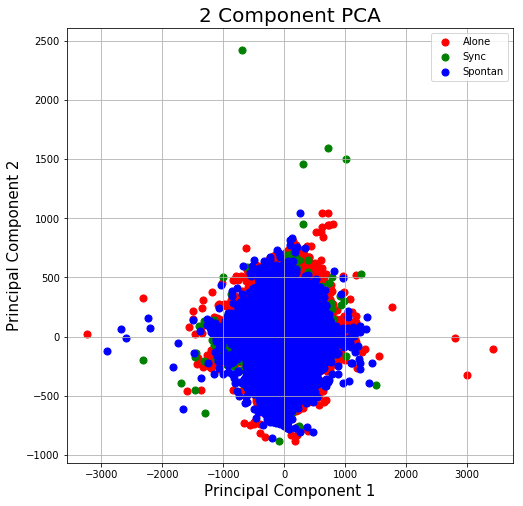

In [8]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 Component PCA', fontsize = 20)


targets = ['Alone', 'Sync', 'Spontan']
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = final['Type'] == target
    ax.scatter(final.loc[indicesToKeep, 1]
               , final.loc[indicesToKeep, 2]
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

Type
Alone      AxesSubplot(0.125,0.125;0.775x0.755)
Spontan    AxesSubplot(0.125,0.125;0.775x0.755)
Sync       AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

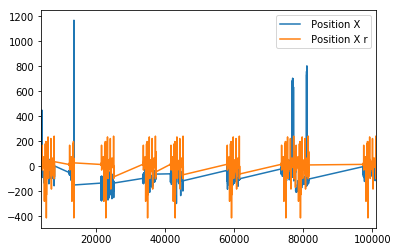

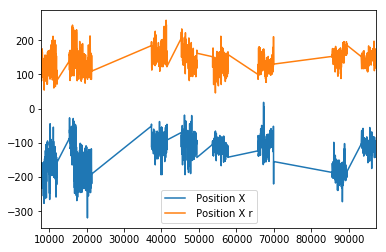

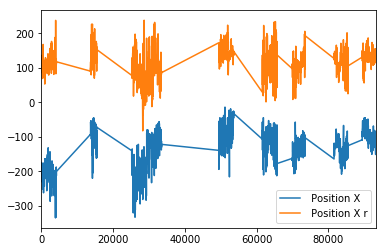

In [9]:
train.groupby(['Type'])[' Position X', ' Position X r'].plot()

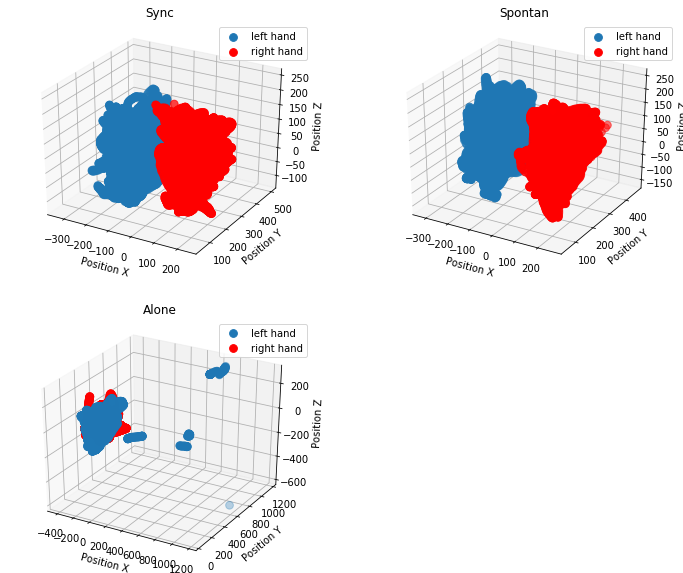

In [10]:
df = train.drop('Name',axis=1)
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(2, 2, 1, projection='3d')
ax.title.set_text('Sync')
plt.gca().legend(('left','right'))
dfS = df[df.Type == 'Sync']
ax.scatter(dfS[' Position X'], dfS[' Position Y'], dfS[' Position Z'],s=60, label='left hand')
ax.scatter(dfS[' Position X r'], dfS[' Position Y r'], dfS[' Position Z r' ], color='red',s=60, label='right hand')
plt.legend()
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Position Z')

ax = fig.add_subplot(2, 2, 2, projection='3d')
ax.title.set_text('Spontan')
dfS = df[df.Type == 'Spontan']
ax.scatter(dfS[' Position X'], dfS[' Position Y'], dfS[' Position Z'],s=60, label='left hand')
ax.scatter(dfS[' Position X r'], dfS[' Position Y r'], dfS[' Position Z r' ], color='red',s=60, label='right hand')
plt.legend()
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Position Z')

ax = fig.add_subplot(2, 2, 3, projection='3d')
ax.title.set_text('Alone')
dfS = df[df.Type == 'Alone']
ax.scatter(dfS[' Position X'], dfS[' Position Y'], dfS[' Position Z'],s=60, label='left hand')
ax.scatter(dfS[' Position X r'], dfS[' Position Y r'], dfS[' Position Z r' ], color='red',s=60, label='right hand')
plt.legend()
ax.set_xlabel('Position X')
ax.set_ylabel('Position Y')
ax.set_zlabel('Position Z')
plt.show()

# Modles and feature selection

In [20]:
from sklearn.dummy import DummyClassifier
dummy_classifier = DummyClassifier(strategy="most_frequent")
dummy_classifier.fit(x_train, y_train)
print(dummy_classifier.score(x_test,y_test))
print(f1_score(y_pred=dummy_classifier.predict(x_test), y_true=y_test, average='weighted'))

0.3427072758037225
0.17494248970760382


In [15]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(x_train, y_train)
print(knn.score(x_test,y_test))
print(f1_score(y_pred=knn.predict(x_test),y_true=y_test,average='weighted'))

0.828155668358714
0.8275600389033537


In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(x_train, y_train)
print(logreg.score(x_test,y_test))

In [ ]:
from sklearn.ensemble import RandomForestClassifier
d_range = list(range(1, 35))
d_scores = []
for d in d_range:
    rfc = RandomForestClassifier(n_estimators=d, max_depth=5,random_state=1,n_jobs=-1)
    rfc.fit(x_train, y_train)
    d_scores.append(rfc.score(x_test,y_test))


# plot the value of max_depth for rfc (x-axis) versus the cross-validated accuracy (y-axis)
plt.plot(d_range, d_scores)
plt.xlabel('Value of n_estimators for rfc')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
from sklearn.ensemble import RandomForestClassifier
d_range = list(range(12, 30))
d_scores = []
for d in d_range:
    pca = PCA(n_components=d)
    pc = pca.fit_transform(x_train)
    pc_t = pca.fit_transform(x_test)
    rfc = RandomForestClassifier(n_estimators=100, max_depth=20,random_state=1,n_jobs=-1)
    rfc.fit(pc, y_train)
    scores = rfc.score(pc_t,y_test)
    d_scores.append(scores.mean())
plt.plot(d_range, d_scores)
plt.xlabel('Value of n PCA components')
plt.ylabel('Cross-Validated Accuracy')

In [ ]:
lg = LogisticRegression(solver='warn',n_jobs=-1)
lg.fit(x_train, y_train)
print(lg.score(x_test,y_test))

In [ ]:
d_range = ['l1', 'l2']
d_scores = []
for d in d_range:
    lg = LogisticRegression(n_jobs=-1, penalty=d)
    lg.fit(x_train, y_train)
    d_scores.append(lg.score(x_test,y_test))
plt.bar(d_range, d_scores)
plt.xlabel('Value of penalty')
plt.ylabel('Accuracy')

In [ ]:
d_range = [0.1,0.5,0.9]
d_scores = []
for d in d_range:
    lg = LogisticRegression(n_jobs=-1, penalty='l1',C=d)
    lg.fit(x_train, y_train)
    d_scores.append(lg.score(x_test,y_test))
drange = ['0.1','0.5','0.9']
plt.bar(drange, d_scores)
plt.xlabel('Value of C')
plt.ylabel('Accuracy')

In [ ]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
gnb.fit(x_train,y_train)
gnb.score(x_test,y_test)

In [ ]:
from sklearn.metrics import roc_curve,auc
from scipy import interp
from itertools import cycle


x = x_train
y = y_train
n_classes=3

model=GaussianNB()
model.fit(x_train,y_train)
nb=model.score(x ,y)

pred1=model.predict(x_test)
t1=sum(x==0 for x in pred1-y_test)/len(pred1)

### MACRO
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(np.array(pd.get_dummies(y_test))[:, i], np.array(pd.get_dummies(pred1))[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])


all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

lw=2
plt.figure(figsize=(8,5))
plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='green', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--',color='red', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.annotate('Random Guess',(.5,.48),color='red')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic for Naive Bayes - IRIS DATASET')
plt.legend(loc="lower right")
plt.show()